In [ ]:
# | echo: false
# | output: false
# | warning: false

from datetime import datetime
from os import path
from os.path import join
from typing import List, Union

import decoupler as dc
import gseapy as gs
import pandas as pd
import panel as pn
import scanpy as sc
import tomlkit
from os.path import join
from datetime import datetime
import panel as pn

pn.extension("tabulator")

In [ ]:
# | echo: true
# | output: false
# | warning: false

CLUSTERING_COL: str = "leiden_1.0"
CONDIITION: Union[str, None] = None
SUBSET: Union[str, List, None] = None

# Check options from gseapy.show_resouces()
ENRICHMENT_DBS: list[str] = []

In [ ]:
# | echo: false
# | output: false
# | warning: false

## Pipeline parameters
with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [ ]:
# | output: false
# | warning: false


# Directories
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])
DIR_samples = config["basic"]["DIR_SAMPLES"]

# Basic information
ORGANISM: str = config["basic"]["ORGANISM"]
NORMALIZATION_METHOD = config["normalization"]["NORMALIZATION_METHOD"]

if CLUSTERING_COL == "":
    CLUSTERING_COL = config["clustering"]["CLUSTERING_COL"]
elif CLUSTERING_COL == "":
    raise ValueError(
        "No clustering column found. please provide a key for cell grouping"
    )

In [ ]:
# | echo: false
# | output: false
# | warning: false

adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))
adata.X = adata.layers[NORMALIZATION_METHOD].copy()

In [6]:
# | echo: false
# | output: false
# | warning: false

sc.tl.rank_genes_groups(
    adata,
    groupby=CLUSTERING_COL,
    mask_var=SUBSET,
    layer=NORMALIZATION_METHOD,
    method="wilcoxon",
    pts=True,
)
sc.tl.filter_rank_genes_groups(adata)

In [7]:
# | echo: false
# | output: false
# | warning: false

cell_types = adata.obs[CLUSTERING_COL].unique().tolist()
de_df = {}
for c_type in cell_types:
    de_df[c_type] = sc.get.rank_genes_groups_df(adata, group=c_type).sort_values(
        by="logfoldchanges", ascending=False
    )

In [8]:
# | echo: false
# | output: false
# | warning: false

writer = pd.ExcelWriter(
    join(DIR_SAVE, datetime.strftime(datetime.now(), "%Y%m%d") + "_DE_results.xlsx"),
    engine="openpyxl",
)
for df_name, df in de_df.items():
    df.to_excel(writer, sheet_name=df_name)
writer.close()

/home/mohamed/Documents/Bioinformatics/GPM/analysis/scRNAseq_pipeline/differential_expression/.pixi/envs/default/lib/python3.9/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [9]:
# | echo: false
# | output: false
# | warning: false

cell_types = adata.obs[CLUSTERING_COL].unique().tolist()
de_df = {}
for c_type in cell_types:
    de_df[c_type] = sc.get.rank_genes_groups_df(
        adata, group=c_type, pval_cutoff=0.05
    ).sort_values(by="logfoldchanges", ascending=False)

In [10]:
# | echo: false
# | warning: false

widget_ls = []
for index, key in enumerate(de_df.keys()):
    widget_ls.append((key, pn.widgets.Tabulator(de_df[key])))

pn.Tabs(*widget_ls)

pn.Tabs(*widget_ls, dynamic=True)

BokehModel(combine_events=True, render_bundle={'docs_json': {'1e0a5050-c9ae-49b6-a98b-3c20062112eb': {'version…

In [ ]:
# | echo: false
# | warning: false

sc.pl.rank_genes_groups(adata)

In [ ]:
# | echo: false
# | warning: false

sc.pl.rank_genes_groups_dotplot(adata)

In [ ]:
# | echo: false
# | warning: false
sc.pl.rank_genes_groups_heatmap(adata)

## Matrix plot

In [ ]:
# | echo: false
# | warning: false

sc.pl.rank_genes_groups_matrixplot(adata)

In [ ]:
progeny = dc.get_progeny(organism=ORGANISM, top=500)
dc.run_mlm(
    mat=adata,
    net=progeny,
    source="source",
    target="target",
    weight="weight",
    verbose=True,
    use_raw=False,
)

acts = dc.get_acts(adata, obsm_key="mlm_estimate")

sc.pl.matrixplot(
    acts,
    var_names=acts.var_names,
    groupby=CLUSTERING_COL,
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="viridis",
)

# Transcription Factor Activity Inference (CollecTRI)

In [ ]:
net = dc.get_collectri(organism=ORGANISM, split_complexes=False)

dc.run_ulm(
    mat=adata,
    net=net,
    source="source",
    target="target",
    weight="weight",
    verbose=True,
    use_raw=False,
)

acts = dc.get_acts(adata, obsm_key="ulm_estimate")

df: pd.DataFrame = dc.rank_sources_groups(
    acts, groupby=CLUSTERING_COL, reference="rest", method="t-test_overestim_var"
)
n_markers = 3
source_markers: pd.DataFrame = (
    df.groupby("group")
    .head(n_markers)
    .groupby("group")["names"]
    .apply(lambda x: list(x))
    .to_dict()
)

sc.pl.matrixplot(
    acts,
    source_markers,
    CLUSTERING_COL,
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="viridis",
)


# Over-representation analysis

In [11]:
msigdb = dc.get_resource("MSigDB")
list(msigdb.collection.unique())

['chemical_and_genetic_perturbations',
 'immunesigdb',
 'mirna_targets_mirdb',
 'go_molecular_function',
 'tf_targets_gtrf',
 'tf_targets_legacy',
 'oncogenic_signatures',
 'cell_type_signatures',
 'vaccine_response',
 'go_biological_process',
 'cancer_gene_neighborhoods',
 'cancer_modules',
 'go_cellular_component',
 'wikipathways',
 'reactome_pathways',
 'hallmark',
 'mirna_targets_legacy',
 'biocarta_pathways',
 'positional',
 'human_phenotype_ontology',
 'pid_pathways',
 'kegg_pathways']

In [15]:
import numpy as np
# TODO: The ORA method is very slow, check other implementations

go = msigdb[msigdb.collection == "go_biological_process"]
go = go[~go.duplicated(["geneset", "genesymbol"])]

dc.run_ora(
    mat=adata,
    net=go,
    source="geneset",
    target="genesymbol",
    verbose=True,
    use_raw=False,
)

acts = dc.get_acts(adata, obsm_key="ora_estimate")

acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e
df = dc.rank_sources_groups(
    acts, groupby="louvain", reference="rest", method="t-test_overestim_var"
)

n_markers = 5
source_markers = (
    df.groupby("group")
    .head(n_markers)
    .groupby("group")["names"]
    .apply(lambda x: list(x))
    .to_dict()
)

sc.pl.matrixplot(
    acts,
    source_markers,
    CLUSTERING_COL,
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="viridis",
)


10811 features of mat are empty, they will be removed.
Running ora on mat with 12327 samples and 25790 targets for 7322 sources.


  0%|          | 0/12327 [00:00<?, ?it/s]

# GSEA enrichment

In [16]:
gene_rank = sc.get.rank_genes_groups_df(adata, group=cell_types[0])[['names','logfoldchanges']]
gene_rank.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)
# filter for genes expressed in at least 30 cells.
gene_rank = gene_rank[gene_rank['names'].isin(adata.var_names[adata.var.n_cells_by_counts>30])]
gene_rank


,names,logfoldchanges
7745,OR5K1,22.595636
8422,AL353747.4,22.043699
9185,UGT1A3,21.959364
8588,OR5H2,21.659765
9525,UGT1A5,21.642721
...,...,...
28009,SEMA5A-AS1,-20.585629
27962,TYRP1,-20.791988
28129,AC109441.1,-20.899433
26944,MT1H,-20.933752


In [19]:
gene_set_names = gseapy.get_library_name(organism=ORGANISM)
res = gseapy.prerank(rnk=gene_rank, gene_sets='GO_Biological_Process_2023')

2024-09-03 14:59:46,250 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/home/mohamed/Documents/Bioinformatics/GPM/analysis/scRNAseq_pipeline/differential_expression/.pixi/envs/default/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/mohamed/Documents/Bioinformatics/GPM/analysis/scRNAseq_pipeline/differential_expression/.pixi/envs/default/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


<Axes: title={'center': 'mast cell'}, xlabel='NES'>

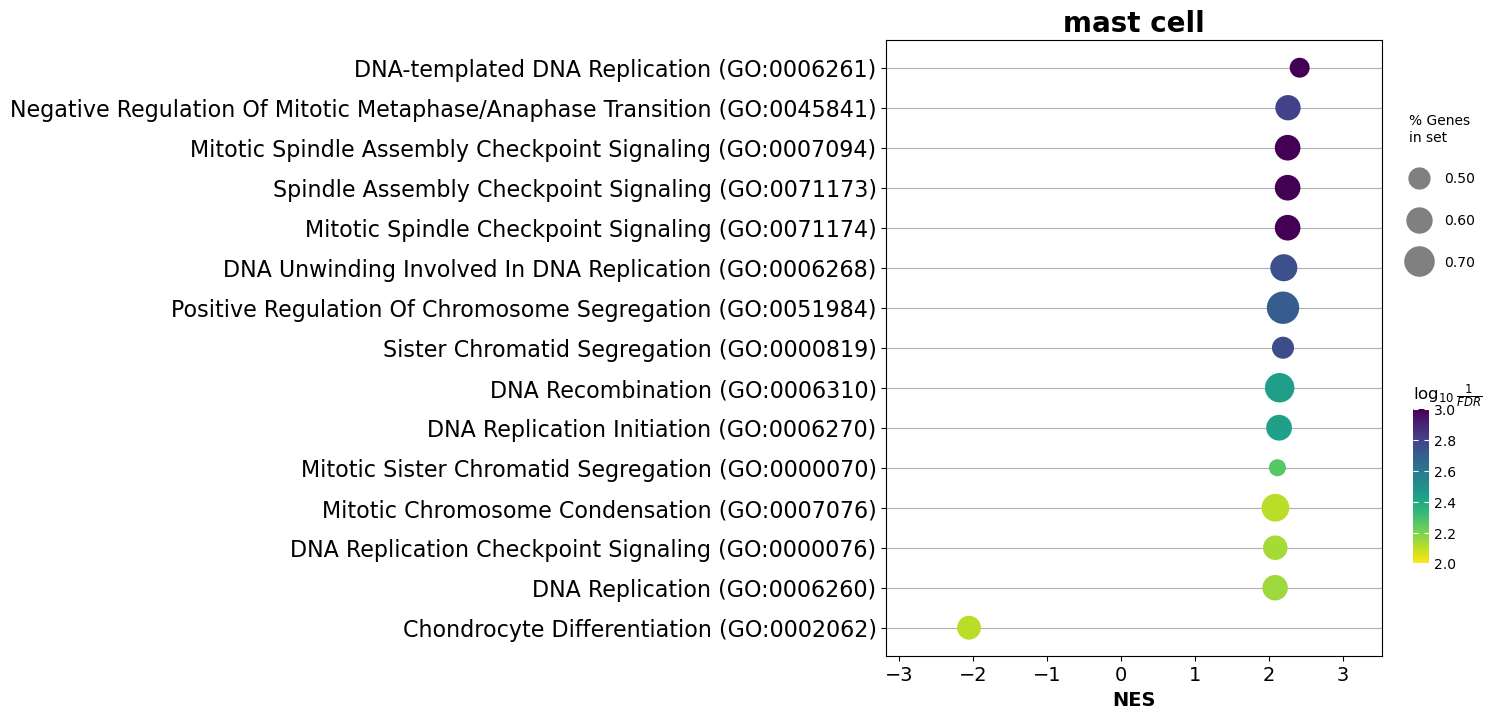

In [40]:
gseapy.dotplot(res.res2d, column="FDR q-val", top_term = 15, figsize=(8,8), title=cell_types[0], size=5)

# Progeny

In [41]:
progeny = dc.get_progeny(organism=ORGANISM, top=500)
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

acts = dc.get_acts(adata, obsm_key='mlm_estimate')
sc.pl.matrixplot(acts, var_names=acts.var_names, groupby=CLUSTERING_COL, dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='viridis')


,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,1.522388e-06
6996,p53,CFDP1,-1.628168,1.526045e-06
6997,p53,VPS37D,2.309503,1.537098e-06
6998,p53,TEDC1,-2.274823,1.547037e-06


# TF enrichment

In [57]:
net = dc.get_collectri(organism='human', split_complexes=False)
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)
acts = dc.get_acts(adata, obsm_key='ulm_estimate')
df = dc.rank_sources_groups(acts, groupby=CLUSTERING_COL, reference='rest', method='t-test_overestim_var')
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()

3657 features of mat are empty, they will be removed.
Running ulm on mat with 31087 samples and 32944 targets for 763 sources.


  0%|          | 0/4 [00:00<?, ?it/s]

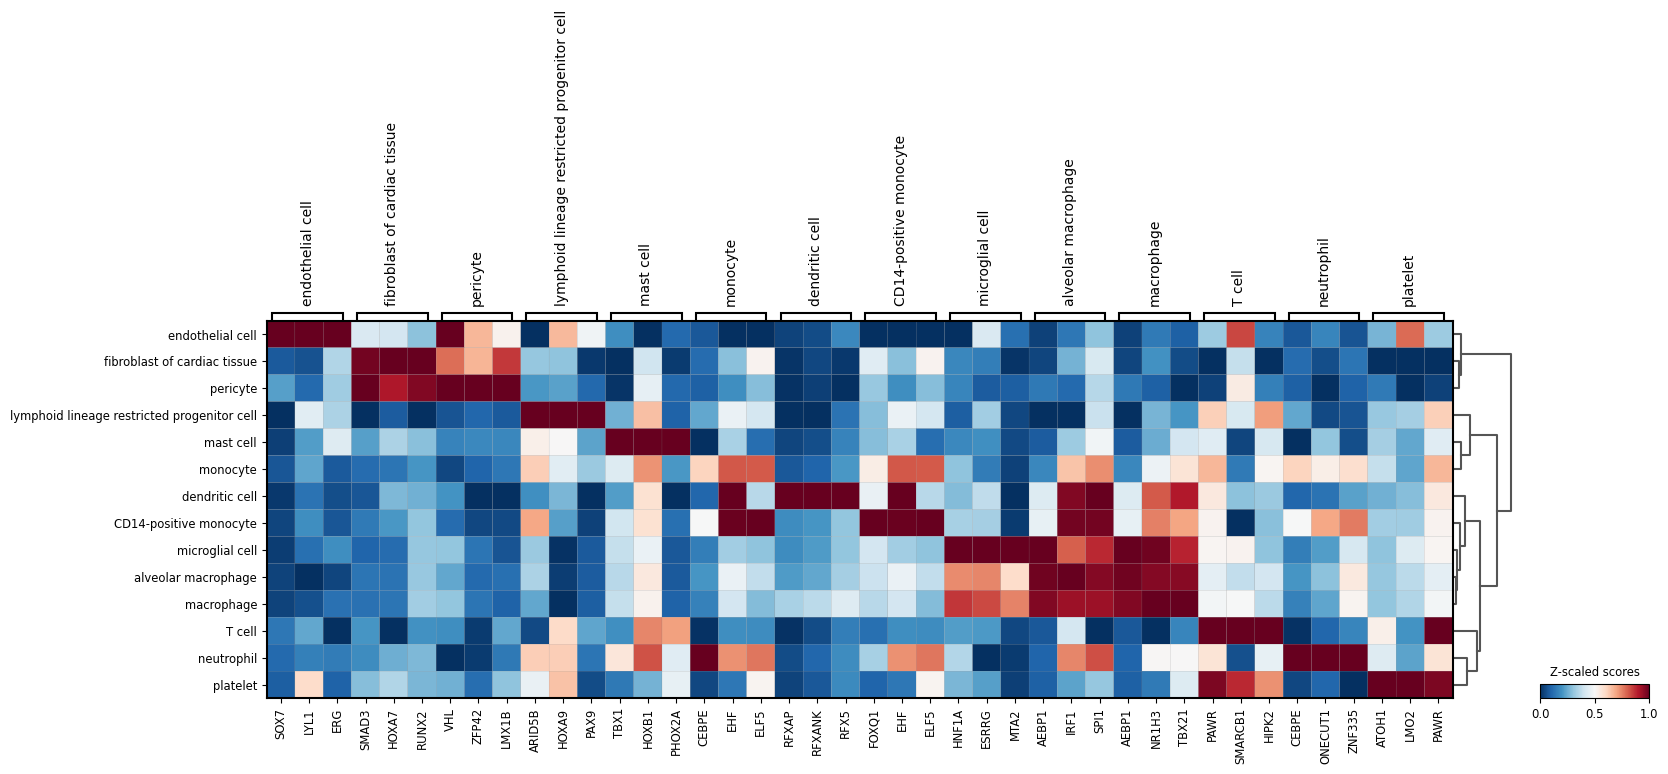

In [59]:
sc.pl.matrixplot(acts, source_markers, CLUSTERING_COL, dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')